In [56]:
!pip install tensorflow==2.16.1 opencv-python matplotlib

In [57]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [58]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [59]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [60]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [61]:
# http://vis-www.cs.umass.edu/lfw/
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

tar: Error opening archive: Failed to open 'lfw.tgz'


In [62]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

In [63]:
# Import uuid library to generate unique image names
import uuid

In [64]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\5f462d7a-3341-11ef-8a25-60452e6c644c.jpg'

In [65]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

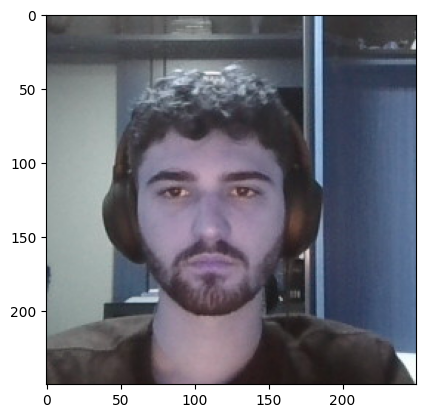

In [66]:
plt.imshow(frame[:250,:250, :])

In [67]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '\\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH + '\\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH + '\\*.jpg').take(3000)

In [68]:
dir_test = anchor.as_numpy_iterator()

In [69]:
print(dir_test.next())

b'data\\anchor\\c6d77405-325c-11ef-ba53-60452e6c644c.jpg'


In [70]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [71]:
img = preprocess('data\\anchor\\e1b4ea4c-325c-11ef-a448-60452e6c644c.jpg')

In [72]:
img.numpy().max() 

1.0

In [73]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [74]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [75]:
samples = data.as_numpy_iterator()

In [76]:
example = samples.next()

In [77]:
example

(b'data\\anchor\\dee037ca-325c-11ef-89c1-60452e6c644c.jpg',
 b'data\\positive\\180f5ee6-325d-11ef-9100-60452e6c644c.jpg',
 1.0)

In [78]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [79]:
res = preprocess_twin(*example)

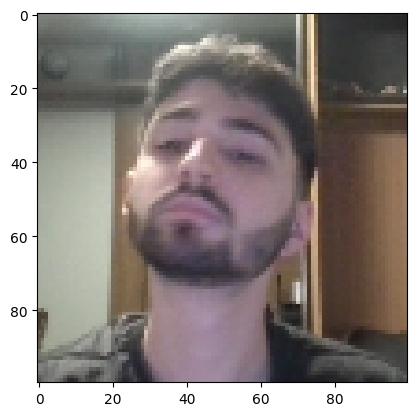

In [49]:
plt.imshow(res[1])

In [50]:
res[2]

1.0

In [51]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [52]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [53]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)